In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xarray as xr

In [3]:
import scipy.signal
import torch
from torch import nn
from torch.utils.data import DataLoader

In [4]:
from Game import Game
from Player import Player
from Event import Event
from Moment import Moment
from Ball import Ball

In [5]:
position_ids = torch.arange(1024)[:, None]
d = 512
a = (position_ids/(10000*2*np.pi/2/np.pi)**(torch.arange(d)/d)).sin()

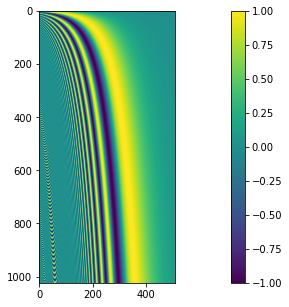

In [6]:
plt.figure(figsize=(20, 5))
plt.imshow(a.numpy()); plt.colorbar()

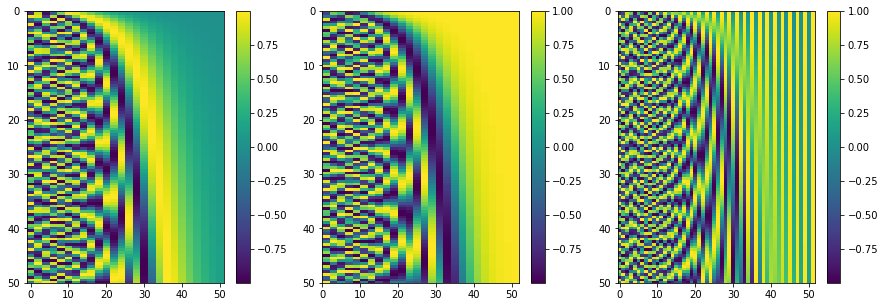

In [7]:
def temp(tmin, tmax, t=None, d=512):
    if t is None:
        t = torch.linspace(tmin, tmax, 1024)
    i = torch.arange(d)
    i_even = i[::2]
    i_odd = i[1::2]
    
    embed = torch.zeros(len(t), d)
    
    wl0 = 2*np.pi *     1 * (tmax-tmin) / 1024
    wl1 = 2*np.pi * 10000 * (tmax-tmin) / 1024
    wavelength = wl0 * (wl1/wl0)**(i_even/d)
    freq = 1./wavelength
    
    a = t[:, None] * 2*np.pi/wavelength
    sin = embed[:, i_even] = a.sin()
    cos = embed[:, i_odd] = a.cos()
    
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.pcolormesh(i_even.numpy(), t.numpy(), sin.numpy()); plt.colorbar()
    plt.ylim(tmax, tmin)
    
    plt.subplot(132)
    plt.pcolormesh(i_odd.numpy(), t.numpy(), cos.numpy()); plt.colorbar()
    plt.ylim(tmax, tmin)
    
    plt.subplot(133)
    plt.pcolormesh(i.numpy(), t.numpy(), embed.numpy()); plt.colorbar()
    plt.ylim(tmax, tmin)
    plt.show()
    return embed
    
a = temp(0, 50, t=torch.linspace(0, 50, 100), d=52)

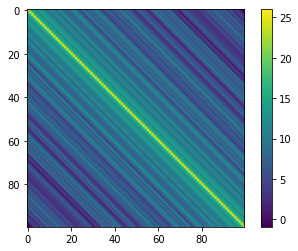

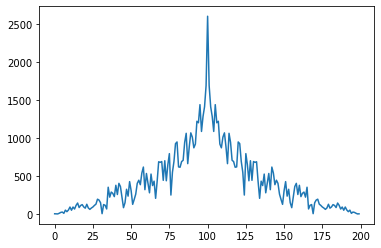

In [8]:
plt.imshow(a@a.T); plt.colorbar()
plt.show()
plt.plot([(a@a.T).diagonal(i).sum().item() for i in range(-100, 100)])
plt.show()

In [9]:
path = 'data/game.json'
game = Game(path)
game.read_json(tqdm=tqdm)

loading  452


  0%|          | 0/452 [00:00<?, ?it/s]

In [10]:
def load_data_game(game):
    data_game = []
    for i_event, event in enumerate(tqdm(game.events)):
        if len(event.moments)==0:
            continue
        data_e = np.full((len(event.moments), 5+3+40), fill_value=np.nan)
        for i_moment, moment in enumerate(event.moments):
            ball = moment.ball
            quarter_clock = moment.game_clock
            game_clock = quarter_clock+(4-moment.quarter)*12*60
            # game_clock = int((game_clock+.005)*100)/100.
            
            data_e[i_moment, :5] = [game_clock, quarter_clock, moment.shot_clock, moment.quarter, 0]#i_event]
            # data_m.extend([moment.game_clock, moment.shot_clock, moment.quarter])
            data_e[i_moment, 5:8] = [ball.x, ball.y, ball.radius]
            # data_m.extend([ball.x, ball.y, ball.radius])

            for i_player, player in enumerate(moment.players):
                data_e[i_moment, 8+(i_player)*4: 8+(i_player+1)*4] = [player.id, player.team.id, player.x, player.y]
                # data_m.extend([player.id, player.team.id, player.x, player.y])
                # sometimes there is not enough players in this loop
                # so manually create a array of nans at the beginning (rather than at the end)
                # and fill the correct player positions
            # data_e.append(data_m)

        # print(np.array([len(i) for i in data_e]).std())
        # print(np.array([len(i) for i in data_e]).min())
        # print(np.array([len(i) for i in data_e]).max())
        # print()
        # data_e = np.array(data_e)
        
        # only add if this new event is different from the previous one
        
        if len(data_game)==0 or not np.array_equal(data_e, data_game[-1], equal_nan=True):
            data_game.append(data_e)
    return data_game
    
def preprocess(data_game):
    # concatenate all events' moments
    data_game = np.concatenate(data_game, axis=0).T
    t = data_game[0]
    
    # only include the first instance of a time stamp (to two decimals)
    t_binned = ((t+0.001)*100).astype(int)
    _, idxs = np.unique(t_binned, return_index=True)
    data_game = data_game[:, idxs]
    
    # sort the times in case they're out of order
    idxs = np.argsort(data_game[0])[::-1]
    data_game = data_game[:, idxs]
    return data_game.T
        
        # break
    # break
# ts, bx = np.array(ts), np.array(bx)
# idxs = []
# t_seen = set()
# pt = 720
# for i, t in enumerate(((ts+0.0001)*100).astype(int)):
#     if pt<5 and t>600:
#         t_seen = set()
#     if t not in t_seen:
#         t_seen.add(t)
#         idxs.append(i)
#     pt = t


# i = np.array(idxs)
# ts, bx = ts[i], bx[i]

In [11]:
dg_raw = load_data_game(game)
dg = preprocess(dg_raw)
# list(zip([e.shape for e in dg_raw], [e[:, 2].sum() for e in dg_raw]))

  0%|          | 0/452 [00:00<?, ?it/s]

In [12]:
np.isnan(dg).any(axis=0)

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True])

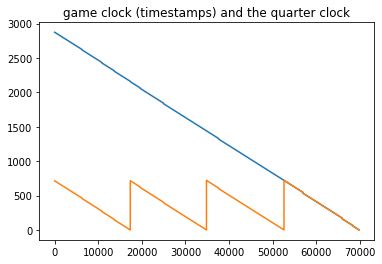

0.02 2873.26
-12.389999999999986 -0.041153284253344406 -0.009999999999763531


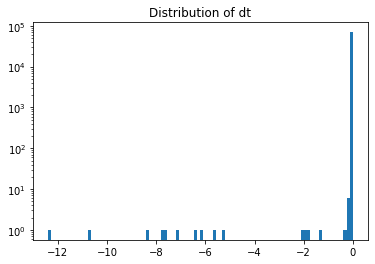

In [13]:
plt.plot(dg[:, 0])
plt.plot(dg[:, 1])
plt.title('game clock (timestamps) and the quarter clock')
plt.show()

t = dg[:, 0]
print(t.min(), t.max())
dt = np.diff(t)
assert (dt<0).all(), 'timestamps not all decreasing'
print(dt.min(), dt.mean(), dt.max())

plt.hist(dt, bins=100);
plt.title('Distribution of dt')
plt.yscale('log')
plt.show()

(-0.05, 0.0)

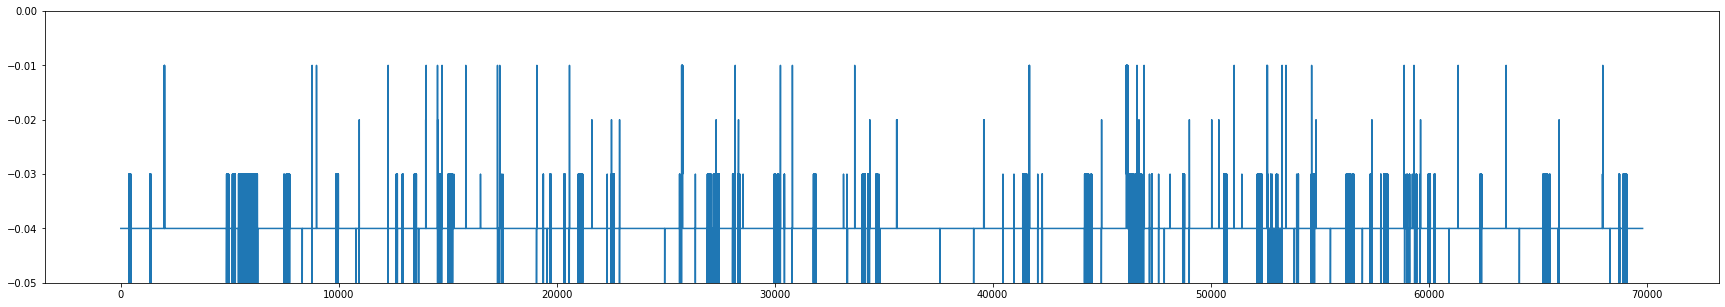

In [14]:
plt.figure(figsize=(30, 5))
plt.plot(dt)
plt.ylim(-.05, 0)

In [15]:
np.abs(dt--0.04)<1e-5

array([ True,  True,  True, ...,  True,  True,  True])

(-0.05, 0.0)

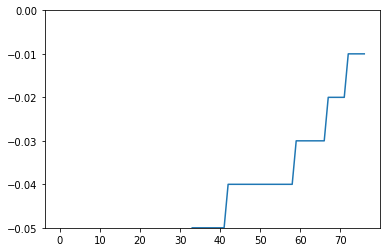

In [16]:
plt.plot(np.unique(dt))
plt.ylim(-.05, 0)

(-5.143629000000001, 99.20278900000001, 0.1835935000000002, 50.7351165)

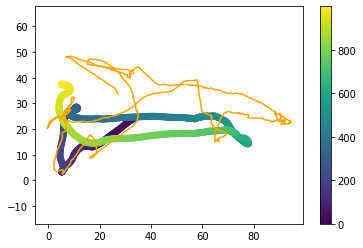

In [17]:
x = dg[:1000, 10]
y = dg[:1000, 11]
plt.scatter(x, y, c=np.arange(len(x)))
plt.colorbar()
x = dg[:1000, 5]
y = dg[:1000, 6]
plt.plot(x,y, color='orange')

plt.axis('equal')
# plt.ylim(0, 50)
# plt.xlim(0, 94)

In [18]:
import torch
from torch import nn

In [19]:
team2onehot = {0: 0, game.home_team.id: 1, game.guest_team.id: 2}
print(len(team2onehot), team2onehot)
ids_p_all = list(game.player_ids_dict.keys())
pid2onehot = {0: 0}
pid2onehot.update({a: idx+1 for idx, a in enumerate(ids_p_all)})
print(len(pid2onehot), pid2onehot)

3 {0: 0, 1610612761: 1, 1610612766: 2}
27 {0: 0, 201949: 1, 2449: 2, 201960: 3, 202709: 4, 200768: 5, 202687: 6, 201942: 7, 202685: 8, 203998: 9, 203082: 10, 202335: 11, 1626153: 12, 203512: 13, 101107: 14, 203087: 15, 201587: 16, 202391: 17, 1626151: 18, 202689: 19, 203798: 20, 203148: 21, 203584: 22, 203469: 23, 1626163: 24, 201946: 25, 201150: 26}


In [20]:
from collections import defaultdict

In [21]:
max_speed_human = 25 # feet per second
max_speed_ball = 70 # feet per second
class BasketballDataset(torch.utils.data.Dataset):
    def __init__(self, dg, input_shot_clock=True, input_p_id=True):
        self.dg = dg
        self.input_shot_clock = input_shot_clock
        self.input_p_id = input_p_id
        self.init_ds()
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return [value[idx] for key, value in self.ds]
    
    def init_ds(self, ):
        
        ds = defaultdict(lambda : [])
        # for i in tqdm(range(4, len(self.dg))):
        for i in tqdm(range(4, 10000)):
            dgi = self.dg[i-4: i]
            if np.isnan(dgi).any(): #ignore nan values
                continue
            t = dgi[:, 0]
            dt = np.diff(t)
            # if (np.abs(dt--0.04) > 1e-4).any():
                # continue
            if (np.abs(np.diff(dgi[:, 0])--0.04) > 1e-4).any():
                # print('skipped on game')
                continue
            if (np.abs(np.diff(dgi[:, 1])--0.04) > 1e-4).any():
                # print('skipped on quarter')
                continue
            if (np.abs(np.diff(dgi[:, 2])--0.04) > .1).any():
                continue
            
            """
            . . . . x,y, :3  can be input
             . . . vx, vy :2 can be input
              . . ax, ay, :1 can be input, 1 is target
            """
            idx_inp_xy = 2
            idx_inp_v = 1
            idx_inp_a = 0
            idx_inp_a_target = 1

            shot_clock = dgi[:, 2] 
            bx, by, bz = dgi[:, 5], dgi[:, 6], dgi[:, 7]

            p = dgi[:, 8:].reshape(-1, 10, 4) # t, 10, 4

            id_p = p[:, :, 0]
            id_team = p[:, :, 1]
            if not (id_p.std(axis=0)<1e-3).all(): # players ids change
                continue
            if not (id_team.std(axis=0)<1e-3).all(): # teams ids change
                continue
            id_p, id_team = id_p[idx_inp_xy], id_team[idx_inp_xy]
            id_p, id_team = np.insert(id_p, 0, 0), np.insert(id_team, 0, 0) # add ball id zero
            
            id_team = np.array([team2onehot[i] for i in id_team.astype(int)])
            id_p = np.array([pid2onehot[i] for i in id_p.astype(int)])
            
            oh_team = nn.functional.one_hot(torch.from_numpy(id_team), len(team2onehot))
            # oh_id = nn.functional.one_hot(id_p, len(pid2onehot))
            
            x = p[:, :, 2]
            y = p[:, :, 3]
            z = np.zeros_like(x)
            x = np.concatenate([bx[:, None], x], axis=-1) # add ball as the first "player"
            y = np.concatenate([by[:, None], y], axis=-1)
            z = np.concatenate([bz[:, None], z], axis=-1)
            
            x = np.stack([x,y,z], axis=-1) # t, players, xyz
            v = np.diff(x, axis=0) # t, players, xyz
            a = np.diff(v, axis=0) # t, players, xyz
            
            dt = dt[idx_inp_v]
            nv = v[idx_inp_a_target] # players, xyz
            x = x[idx_inp_xy] # players, xyz
            v = v[idx_inp_v]/dt # players, xyz
            a = a[idx_inp_a]/dt/dt # players, xyz
            
            # xva = np.concatenate([xyz, dxyz, ddxyz], axis=-1) # players, [xyzdxyzddxyz]

            # x_batch = []

            # if self.input_shot_clock:
                # shot_clock = shot_clock[idx_inp_xy]
                # x_batch.append(np.full((len(xva), 1), fill_value=shot_clock))
            # if self.input_p_id:
                # x_batch.append(oh_p_id)
            # x_batch.append(id_team)
            # x_batch.append(oh_team)
            # x_batch.append(xva)
            
            ds['shot_clock'].append(torch.tensor(shot_clock[idx_inp_xy]))
            ds['dt'].append(torch.tensor(dt))
            ds['team'].append(torch.from_numpy(id_team))
            ds['x'].append(torch.from_numpy(x))
            ds['v'].append(torch.from_numpy(v))
            ds['a'].append(torch.from_numpy(a))
            ds['nv'].append(torch.from_numpy(nv))
            # x_batch = torch.from_numpy(np.concatenate(x_batch, axis=-1))
            # ds.append([x_batch, y_batch])
        
        for key, value in ds.items():
            ds[key] = torch.stack(value, dim=0)
            setattr(self, key, ds[key])
        mask1 = (self.v[:, [0], :].norm(dim=-1)<max_speed_ball).all(dim=-1)
        mask2 = (self.v[:,  1:, :].norm(dim=-1)<max_speed_human).all(dim=-1)
        mask = torch.stack([mask1, mask2], dim=0).all(dim=0)
        for key, value in ds.items():
            ds[key] = value[mask]
            setattr(self, key, ds[key])
        self.ds = ds
            
        # self.x = torch.stack([batch[0] for batch in ds]).float()
        
        # v = (self.x[:, :, [7,8,9]].norm(dim=-1)/.04)
        # self.x = self.x[(v[:, 1:]<max_speed_human).all(dim=-1)]
        
        # self.y = torch.stack([batch[1] for batch in ds]).float()
        # a1 = torch.logical_and(self.y[:, :, 0]>=0., self.y[:, :, 1]>=0.)
        # a2 = torch.logical_and(self.y[:, :, 0]>=0., self.y[:, :, 1]<0.)
        # a3 = torch.logical_and(self.y[:, :, 0]<0., self.y[:, :, 1]>=0.)
        # a4 = torch.logical_and(self.y[:, :, 0]<0., self.y[:, :, 1]<0.)
        # self.y = torch.stack([a1, a2, a3, a4], dim=-1).float().argmax(dim=-1)

In [22]:
ds = BasketballDataset(dg, input_shot_clock=True, input_p_id=False)
# x_mean = ds.x.mean(axis=(0, 1))
# x_std = ds.x.std(axis=(0, 1))
# y_mean = ds.y.mean(axis=(0, 1))
# y_std = ds.y.std(axis=(0, 1))
# print([i.shape for i in ds[0]])
# print(len(ds))

  0%|          | 0/9996 [00:00<?, ?it/s]

In [23]:
ds.x.shape

torch.Size([8139, 11, 3])

In [24]:
for batch_idx in torch.randperm(len(ds.x)).split(32):
    data = {key: value[batch_idx] for key, value in ds.ds.items()}

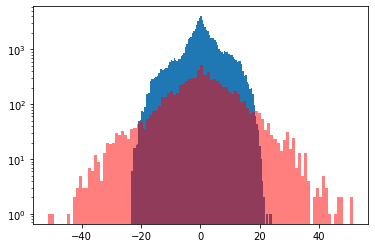

In [722]:
plt.hist(ds.v[:, 1:, 0].flatten().numpy(), bins=100);
plt.hist(ds.v[:, 0, 0].flatten().numpy(), bins=100, color=[1,0,0,.5]);
plt.yscale('log')
plt.show()

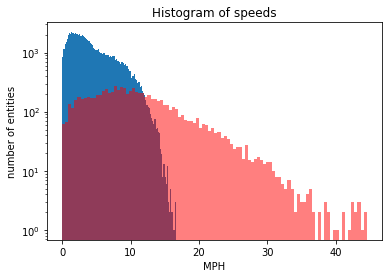

In [723]:
speed = (ds.v.norm(dim=-1))
plt.title('Histogram of speeds')
plt.xlabel('MPH'); plt.ylabel('number of entities')
plt.hist(speed[:, 1:].flatten().numpy()/1.467, bins=100, label='Players');
plt.hist(speed[:, 0].flatten().numpy()/1.467, bins=100, color=[1,0,0,.5], label='Ball');
plt.yscale('log')

In [724]:
v = ds.v

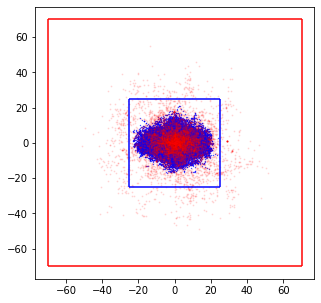

In [725]:
plt.figure(figsize=(5,5))
plt.scatter(v[:, 1:, 0].flatten().numpy(), v[:, 1:, 1].flatten().numpy(), s=.1, color=[0., 0., 1., 1.])
plt.vlines([-max_speed_human, max_speed_human], -max_speed_human, max_speed_human, color='b')
plt.hlines([-max_speed_human, max_speed_human], -max_speed_human, max_speed_human, color='b')

plt.scatter(v[:, 0, 0].flatten().numpy(), v[:, 0, 1].flatten().numpy(), s=1, color=[1., 0, 0, .1])
plt.vlines([-max_speed_ball, max_speed_ball], -max_speed_ball, max_speed_ball, color='r')
plt.hlines([-max_speed_ball, max_speed_ball], -max_speed_ball, max_speed_ball, color='r')
plt.show()


(0.0, 50.0)

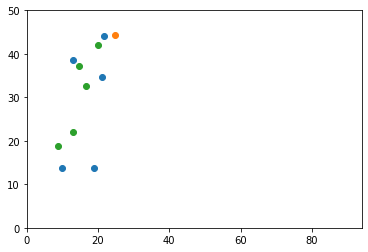

In [726]:
frame_idx = 50
plt.scatter(*ds.x[frame_idx, 1:6][:, :2].numpy().T)
plt.scatter(*ds.x[frame_idx, :1][:, :2].numpy().T)
plt.scatter(*ds.x[frame_idx, 6:][:, :2].numpy().T)
plt.xlim(0, 94)
plt.ylim(0, 50)

4


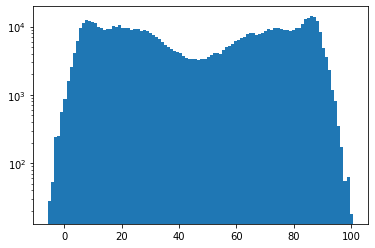

tensor(-5.6625) tensor(100.6232) tensor(47.4659) tensor(28.8095)
5


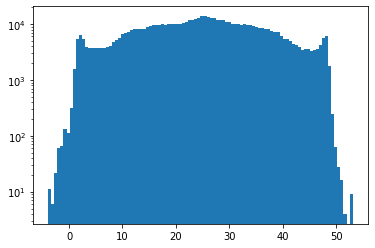

tensor(-3.8903) tensor(53.0736) tensor(24.8453) tensor(11.4727)
6


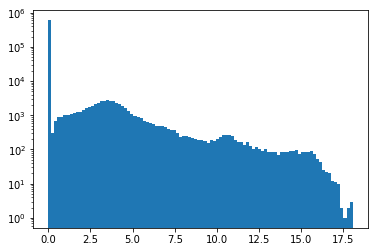

tensor(0.) tensor(18.0520) tensor(0.3985) tensor(1.5477)
7


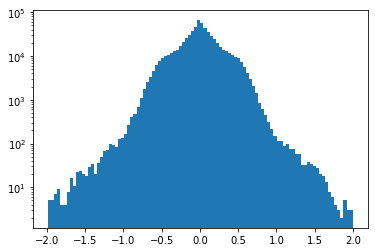

tensor(-1.9840) tensor(1.9969) tensor(0.0012) tensor(0.2870)
8


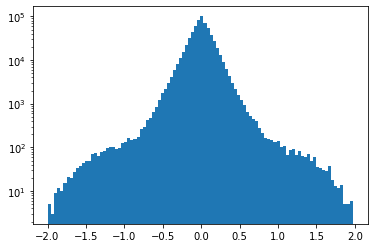

tensor(-1.9902) tensor(1.9715) tensor(-0.0013) tensor(0.1888)
9


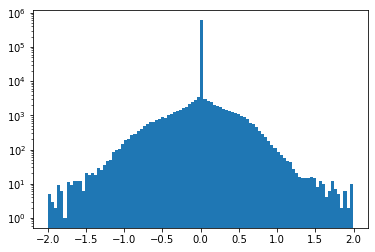

tensor(-1.9923) tensor(1.9872) tensor(0.0003) tensor(0.1248)
10


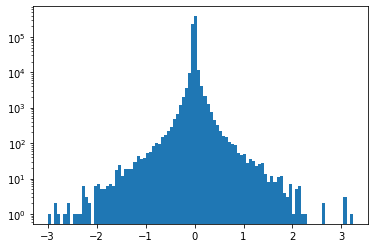

tensor(-2.9866) tensor(3.2281) tensor(1.3718e-05) tensor(0.0737)
11


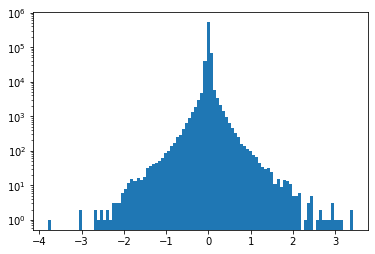

tensor(-3.7918) tensor(3.4168) tensor(8.9651e-06) tensor(0.0926)
12


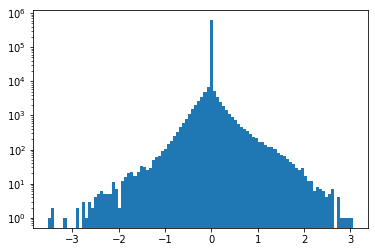

tensor(-3.5229) tensor(3.0504) tensor(-3.6099e-05) tensor(0.1169)


In [190]:
for i in range(4, 13):
    print(i)
    a = ds.x[:, :, i]
    plt.hist(a.flatten().numpy(), bins=100);
    plt.yscale('log');plt.show()
    print(a.min(), a.max(), a.mean(), a.std())

In [460]:
dl = DataLoader(ds, 32, shuffle=True)

In [465]:
for x_batch, y_batch in tqdm(dl):
    # x_batch, y_batch = (x_batch-x_mean)/x_std, (y_batch-y_mean)/y_std
    assert not (x_batch.isnan().any())
    assert not (y_batch.isnan().any())
    
    # plt.plot(x_batch.mean(dim=(0,1)).numpy())
    # plt.plot(x_batch.std(dim=(0,1)).numpy())
    break

  0%|          | 0/1882 [00:00<?, ?it/s]

torch.Size([32, 11, 13]) torch.Size([32, 11])


In [465]:
x = dg[:, 5]
y = dg[:, 6]
print(x.mean(), x.std())
print(y.mean(), y.std())

47.07256216789126 26.851381208031167
25.27347185436629 11.04421297043111


In [468]:
print(94/2., np.sqrt(1/12.)*(94.))
print(50/2., np.sqrt(1/12.)*(50.))

47.0 27.13546265191241
25.0 14.433756729740644


# things to track for this experiment:
- ball x, ball y
- p1 x, p1 y, p1 vx, p1 vy, p1 ax, p1 ay
- ...


# outputs
- movements


In [61]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, final_dim=None, dropout=0.):
        super().__init__()
        if final_dim is None:
            final_dim = dim
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, final_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)
    
class ModelNet(nn.Module):
    def __init__(self, n_inputs=13, n_outputs=3, embed_dim=60, n_heads=4, mlp_dim=100, n_layers=5, dropout=0.0, residual=True):
        super().__init__()
        self.lin_in = nn.Linear(n_inputs, embed_dim)
        self.residual = residual
        
        self.norms1 = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(n_layers)])
        self.attns = nn.ModuleList([nn.MultiheadAttention(embed_dim, n_heads, batch_first=True, dropout=dropout) for _ in range(n_layers)])
        
        self.mlps = nn.ModuleList([MLP(embed_dim, mlp_dim, dropout=dropout) for _ in range(n_layers)])
        self.norms2 = nn.ModuleList([nn.LayerNorm(embed_dim) for _ in range(n_layers)])
        
        self.lin_out = nn.Linear(embed_dim, n_outputs)
        
    def forward(self, x):
        
        x = self.lin_in(x)
        
        # norm attention res, norm mlp res
        for i_layer, (norm1, attn, norm2, mlp) in enumerate(zip(self.norms1, self.attns, self.norms2, self.mlps)):
            a = norm1(x)
            a, _ = attn(a, a, a)
            x = x+a if self.residual else a
            
            a = norm2(x)
            a = mlp(a)
            x = x+a if self.residual else a
            
        x = self.lin_out(x)
        
        # return x.tanh()*4.
        return x
    
net = ModelNet()
# net(x_batch).shape

In [62]:
dl = DataLoader(ds, 1024, shuffle=True)

In [72]:
net = ModelNet()
for p in net.parameters():
    p.data[...] = 1e-3*torch.randn_like(p)

opt = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []
for idx_epoch in range(1):
    pbar = tqdm(dl)
    for idx_batch, (x_batch, y_batch) in enumerate(pbar):
        x_batch, y_batch = (x_batch-x_mean)/x_std, (y_batch-y_mean)/y_std
        assert not (x_batch.isnan().any())
        assert not (y_batch.isnan().any())

        y_batch_pred = net(x_batch)
        loss = (y_batch_pred-y_batch).pow(2.).mean()

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        pbar.set_postfix({'loss': loss.item()})



  0%|          | 0/59 [00:00<?, ?it/s]

In [75]:
np.sum([p.numel() for p in net.parameters()])

136223

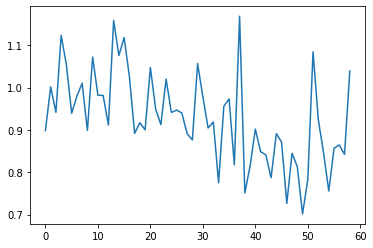

In [73]:
plt.plot(losses)
# plt.ylim(0, 1.)
plt.show()
# plt.plot(np.array(losses).reshape(1, -1).mean(axis=-1))
# plt.show()

In [67]:
net_trained = net

In [68]:
x = ds.x[0]

In [69]:
net_trained(ds.x[300][None])

tensor([[[ 1.7687, -0.1732, -0.9553],
         [ 1.8371,  0.2190, -0.4857],
         [ 3.8098,  0.2376, -0.2783],
         [ 2.8397,  2.2233, -1.7608],
         [ 0.9065,  2.6031, -2.2588],
         [ 2.0179, -0.0531, -0.2550],
         [ 1.5440, -0.1638, -0.3686],
         [ 2.2012, -0.3668, -0.2177],
         [ 1.9179,  0.1847, -0.6012],
         [ 1.1352, -0.2144, -0.3804],
         [ 1.2769,  0.9300, -1.2250]]], grad_fn=<AddBackward0>)

In [71]:
(ds.y[0]-y_mean)/y_std

tensor([[ 7.1347e-01, -4.3416e+00,  8.9022e-02],
        [-6.5337e-02, -5.1932e-02,  1.7719e-05],
        [ 4.2356e-02,  1.3747e-02,  1.7719e-05],
        [ 3.9894e-01, -2.3493e-01,  1.7719e-05],
        [-3.4271e-01,  2.5832e-01,  1.7719e-05],
        [ 2.9064e-02, -1.0206e-01,  1.7719e-05],
        [ 8.8336e-02,  8.1297e-03,  1.7719e-05],
        [ 8.2233e-02, -7.7642e-02,  1.7719e-05],
        [ 2.4771e-01, -4.9413e-03,  1.7719e-05],
        [ 1.4435e-01, -3.8606e-01,  1.7719e-05],
        [-3.1599e-01, -4.1778e-02,  1.7719e-05]])

In [1]:
import torch
from torch import nn

In [9]:
class EncoderNet(nn.Module):
    def __init__(self, n_input=4, embed_dim=60, n_heads=4, n_layers=5):
        super().__init__()
        self.lin_proj = nn.Linear(n_input, embed_dim)
        
        self.attns = nn.ModuleList([nn.MultiheadAttention(embed_dim, n_heads, batch_first=True) for _ in range(n_layers)])
        self.lins = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for _ in range(n_layers)])
        
    def forward(self, x):
        
        x = self.lin_proj(x)
        
        for i_layer, attn, lin in enumerate(zip(self.attn, self.lins)):
            x = attn(x)
            
            x = lin(x)
        
        return x
    
class OffenseNet(nn.Module):
    def __init__(self, n_outputs=2, encoder=None):
        super().__init__()
        self.encoder = encoder
    def forward(self, x):
        return x
    
class DefenseNet(nn.Module):
    def __init__(self, n_outputs=2, encoder=None):
        super().__init__()
        self.encoder = encoder
    def forward(self, x):
        return x
    
enet = EncoderNet()
onet = OffenseNet()
dnet = DefenseNet()